# Difficulty Model v3

This notebook is the pipeline. It includes a robust numeric cleaning/winsorization step before fitting calibrated models to avoid `inf` / extremely large values errors. The notebook trains calibrated Logistic Regression, Random Forest, and XGBoost using full dataset features, produces calibration plots per class, exports artifacts, and provides an inference helper.

**File:** `difficulty_training_combined_v4.csv` must be present in the working directory. Run cells in order.

In [26]:
# Imports
import os, json, joblib, re
import numpy as np
import pandas as pd  # keep pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

print('Imports OK')

Imports OK


In [27]:
# --- Load dataset ---
DATA_PATH = 'difficulty_training_combined_v4.csv'
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f'Dataset not found at {DATA_PATH} — upload the CSV to the notebook folder.')
df = pd.read_csv(DATA_PATH, low_memory=False)
df['question_text'] = df['question_text'].fillna('').astype(str)
print('Loaded df shape:', df.shape)

Loaded df shape: (18003, 59)


## Feature engineering — text features (ARI, TF-IDF L2 norm, readability, keyword density, format tags)

In [28]:
# Text feature functions
import re
def compute_ari(text):
    sentences = re.split(r'[.!?]+', str(text))
    sentences = [s for s in sentences if s.strip()]
    num_sent = max(1, len(sentences))
    words = str(text).split()
    num_words = max(1, len(words))
    chars = sum(len(w) for w in words)
    return 4.71*(chars/num_words) + 0.5*(num_words/num_sent) - 21.43

KEYWORDS = ['not','except','only','unless','never','always','but','without']

def keyword_features(text):
    t = str(text).lower()
    words = t.split()
    wc = len(words) if words else 0
    out = {}
    for kw in KEYWORDS:
        c = t.count(kw)
        out[f'kw_{kw}_count'] = int(c)
        out[f'kw_{kw}_density'] = float(c/wc) if wc else 0.0
    numtok = len(re.findall(r'\d+', t))
    out['num_count'] = int(numtok)
    out['num_density'] = float(numtok/wc) if wc else 0.0
    out['has_number'] = int(numtok>0)
    return out

def avg_word_len(text):
    toks = str(text).split()
    return float(sum(len(w) for w in toks)/len(toks)) if toks else 0.0

def format_features(text):
    t = str(text).lower().strip()
    return {
        'is_wh_question': int(any(t.startswith(w) for w in ['what','which','when','where','why','how'])),
        'is_numeric_question': int(('how many' in t) or any(ch.isdigit() for ch in t)),
        'is_true_false': int(('true or false' in t) or ('t/f' in t) or ('yes/no' in t)),
        'has_blank': int(('___' in t) or ('____' in t)),
    }

# Apply text features
df['ari'] = df['question_text'].apply(compute_ari)

# TF-IDF and L2 norm
texts = df['question_text'].astype(str).tolist()
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(texts)
row_sq_sum = tfidf_matrix.multiply(tfidf_matrix).sum(axis=1)
df['tfidf_l2_norm'] = np.sqrt(np.asarray(row_sq_sum).ravel()).astype(float)

df['readability_score'] = df['question_text'].apply(avg_word_len)
kw_df = df['question_text'].apply(keyword_features).apply(pd.Series)
kw_df.columns = [str(c) for c in kw_df.columns]
df = pd.concat([df.reset_index(drop=True), kw_df.reset_index(drop=True)], axis=1)
fmt_df = df['question_text'].apply(format_features).apply(pd.Series)
fmt_df.columns = [str(c) for c in fmt_df.columns]
df = pd.concat([df.reset_index(drop=True), fmt_df.reset_index(drop=True)], axis=1)

print('Text features added; df.shape =', df.shape)

Text features added; df.shape = (18003, 85)


## Prepare X and y — include full dataset features; drop leakage & embeddings

In [29]:
TARGET = 'difficulty_label'
df_model = df[df[TARGET].isin(['easy','medium','hard'])].copy()
print('df_model shape:', df_model.shape)

# Drop leakage columns and identifiers
drop_cols = ['difficulty_numeric','difficulty_score','empirical_difficulty','percent_incorrect','item_id','problem_id']
embed_like = [c for c in df_model.columns if str(c).lower().startswith('emb')]
drop_cols += embed_like

feature_cols = [c for c in df_model.columns if c not in drop_cols + [TARGET]]
print('Candidate feature columns count:', len(feature_cols))

df_model shape: (18003, 85)
Candidate feature columns count: 47


In [30]:
# Separate numeric and categorical (exclude question_text as raw)
raw_feature_cols = [c for c in feature_cols if c != 'question_text']
numeric_cols = df_model[raw_feature_cols].select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = df_model[raw_feature_cols].select_dtypes(include=['object','bool']).columns.tolist()

# Add text-derived numeric features if not present
text_derived_feats = ['ari','tfidf_l2_norm','readability_score'] + [f'kw_{kw}_count' for kw in KEYWORDS] + [f'kw_{kw}_density' for kw in KEYWORDS] + ['num_count','num_density','has_number','is_wh_question','is_numeric_question','is_true_false','has_blank']
for c in text_derived_feats:
    if c not in numeric_cols and c in df_model.columns:
        numeric_cols.append(c)

print('Numeric cols count:', len(numeric_cols))
print('Categorical cols count:', len(categorical_cols))

Numeric cols count: 44
Categorical cols count: 2


In [31]:
# Build X and y
X = df_model[numeric_cols + categorical_cols].copy()
y = df_model[TARGET].copy()
print('X shape:', X.shape, 'y shape:', y.shape)

X shape: (18003, 46) y shape: (18003,)


In [32]:
# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('Label classes:', le.classes_.tolist())

Label classes: ['easy', 'hard', 'medium']


In [33]:
# Train/val split
X_train, X_val, y_train_enc, y_val_enc = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
print('Train/val shapes:', X_train.shape, X_val.shape)

Train/val shapes: (14402, 46) (3601, 46)


In [34]:
# --- CLEAN & SAFE numeric preprocessing before model.fit ----------
import numpy as np

def clean_numeric_dataframe(df_in, numeric_cols, clip_quantiles=(0.01, 0.99), verbose=True):
    df_clean = df_in.copy()
    report = {'cols_with_inf': [], 'cols_winsorized': []}
    # Replace inf with NaN
    for c in numeric_cols:
        if c in df_clean.columns:
            # replace inf
            col = df_clean[c]
            if np.isinf(col.values).any():
                df_clean[c].replace([np.inf, -np.inf], np.nan, inplace=True)
                report['cols_with_inf'].append(c)
    # Coerce to float64
    for c in numeric_cols:
        if c in df_clean.columns:
            df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce').astype('float64')
    # Winsorize/clipping
    lower_q, upper_q = clip_quantiles
    if lower_q is not None and upper_q is not None:
        for c in numeric_cols:
            if c in df_clean.columns:
                s = df_clean[c].dropna()
                if s.empty:
                    continue
                qlow = s.quantile(lower_q)
                qhigh = s.quantile(upper_q)
                if qlow == qhigh:
                    continue
                if (s < qlow).any() or (s > qhigh).any():
                    df_clean[c] = df_clean[c].clip(lower=qlow, upper=qhigh)
                    report['cols_winsorized'].append(c)
    # Final checks
    any_inf = np.isinf(df_clean[numeric_cols].values).any()
    total_nans = int(df_clean[numeric_cols].isna().sum().sum())
    if verbose:
        print('Clean report — inf cols:', report['cols_with_inf'], 'winsorized:', report['cols_winsorized'])
        print('Post-clean — any_inf:', any_inf, 'total_nans_in_numeric:', total_nans)
    return df_clean, report

# Apply cleaning to X_train and X_val
print('Cleaning numeric features...')
X_train_clean, rep_train = clean_numeric_dataframe(X_train, numeric_cols, clip_quantiles=(0.01,0.99), verbose=True)
X_val_clean, rep_val = clean_numeric_dataframe(X_val, numeric_cols, clip_quantiles=(0.01,0.99), verbose=True)

# Replace X_train/X_val
X_train = X_train_clean
X_val = X_val_clean
print('Numeric cleaning complete')

Cleaning numeric features...
Clean report — inf cols: ['avg_time_per_attempt'] winsorized: ['avg_attempt_count', 'avg_response_time', 'avg_time_per_attempt', 'num_attempts_total', 'num_students', 'text_length', 'word_count', 'ari', 'tfidf_l2_norm', 'readability_score']
Post-clean — any_inf: False total_nans_in_numeric: 158498
Clean report — inf cols: ['avg_time_per_attempt'] winsorized: ['avg_attempt_count', 'avg_response_time', 'avg_time_per_attempt', 'cat_Entertainment: Books', 'num_attempts_total', 'num_students', 'text_length', 'ari', 'tfidf_l2_norm', 'readability_score']
Post-clean — any_inf: False total_nans_in_numeric: 39582
Numeric cleaning complete


In [35]:
# Preprocessor
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_cols),('cat', categorical_transformer, categorical_cols)])
print('Preprocessor defined')

Preprocessor defined


In [36]:
# Model pipelines and calibrated wrappers
lr_base = Pipeline(steps=[('preprocess', preprocessor), ('model', LogisticRegression(max_iter=1000, multi_class='multinomial', class_weight='balanced'))])
rf_base = Pipeline(steps=[('preprocess', preprocessor), ('model', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced'))])
gb_base = Pipeline(steps=[('preprocess', preprocessor), ('model', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, verbosity=0))])

lr_cal = CalibratedClassifierCV(estimator=lr_base, cv=3, method='sigmoid')
rf_cal = CalibratedClassifierCV(estimator=rf_base, cv=3, method='sigmoid')
gb_cal = CalibratedClassifierCV(estimator=gb_base, cv=3, method='sigmoid')

print('Fitting calibrated models... this may take several minutes')

Fitting calibrated models... this may take several minutes


In [37]:
# Fit models (wrapped in try/except to capture errors)
try:
    lr_cal.fit(X_train, y_train_enc)
    rf_cal.fit(X_train, y_train_enc)
    gb_cal.fit(X_train, y_train_enc)
    print('Calibrated models fitted')
except Exception as e:
    print('Error during fit:', type(e).__name__, e)
    raise

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Calibrated models fitted


In [38]:
# Evaluate on validation
y_val_str = le.inverse_transform(y_val_enc)
y_pred_lr = le.inverse_transform(lr_cal.predict(X_val))
y_pred_rf = le.inverse_transform(rf_cal.predict(X_val))
y_pred_gb = le.inverse_transform(gb_cal.predict(X_val))

print('=== Logistic Regression ===')
print('Accuracy:', accuracy_score(y_val_str, y_pred_lr))
print('Macro F1:', f1_score(y_val_str, y_pred_lr, average='macro'))
print(classification_report(y_val_str, y_pred_lr))

print('\n=== Random Forest ===')
print('Accuracy:', accuracy_score(y_val_str, y_pred_rf))
print('Macro F1:', f1_score(y_val_str, y_pred_rf, average='macro'))
print(classification_report(y_val_str, y_pred_rf))

print('\n=== XGBoost ===')
print('Accuracy:', accuracy_score(y_val_str, y_pred_gb))
print('Macro F1:', f1_score(y_val_str, y_pred_gb, average='macro'))
print(classification_report(y_val_str, y_pred_gb))

=== Logistic Regression ===
Accuracy: 0.9897250763676756
Macro F1: 0.989693358024477
              precision    recall  f1-score   support

        easy       1.00      1.00      1.00      1204
        hard       0.98      0.99      0.99      1071
      medium       0.99      0.98      0.99      1326

    accuracy                           0.99      3601
   macro avg       0.99      0.99      0.99      3601
weighted avg       0.99      0.99      0.99      3601


=== Random Forest ===
Accuracy: 0.9997222993612885
Macro F1: 0.9997358912836661
              precision    recall  f1-score   support

        easy       1.00      1.00      1.00      1204
        hard       1.00      1.00      1.00      1071
      medium       1.00      1.00      1.00      1326

    accuracy                           1.00      3601
   macro avg       1.00      1.00      1.00      3601
weighted avg       1.00      1.00      1.00      3601


=== XGBoost ===
Accuracy: 0.9983337961677312
Macro F1: 0.99831153425676

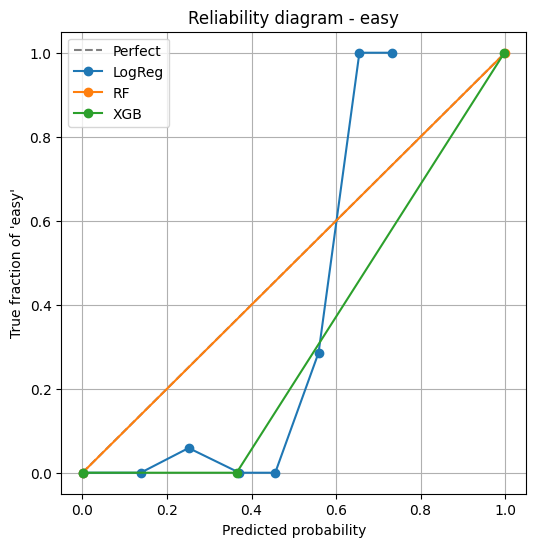

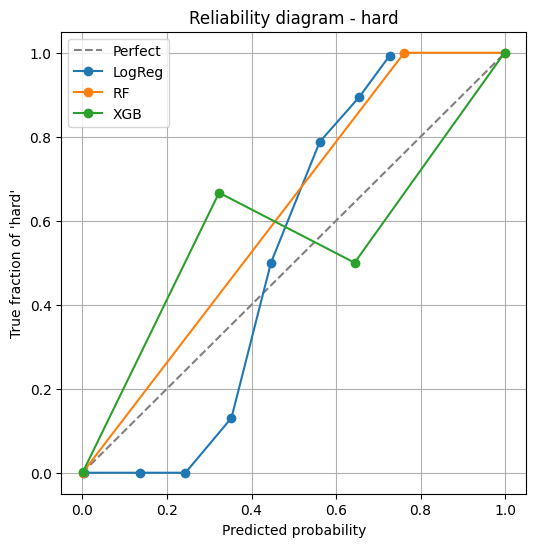

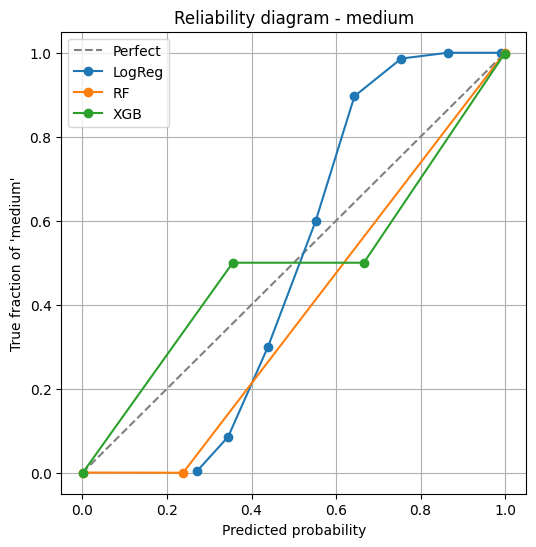

In [39]:
# Multiclass calibration plots
from sklearn.calibration import calibration_curve
classes = list(le.classes_)

def plot_multiclass_calibration(models, names, X_val, y_val_enc, classes, n_bins=10):
    for cls_idx, cls_name in enumerate(classes):
        plt.figure(figsize=(6,6))
        plt.title(f'Reliability diagram - {cls_name}')
        plt.plot([0,1],[0,1],'--',color='gray',label='Perfect')
        for m, name in zip(models, names):
            prob = m.predict_proba(X_val)[:, list(m.classes_).index(cls_idx)]
            true_binary = (y_val_enc == cls_idx).astype(int)
            frac_pos, mean_pred = calibration_curve(true_binary, prob, n_bins=n_bins)
            plt.plot(mean_pred, frac_pos, marker='o', label=name)
        plt.xlabel('Predicted probability')
        plt.ylabel(f"True fraction of '{cls_name}'")
        plt.legend()
        plt.grid(True)
        plt.show()

plot_multiclass_calibration([lr_cal, rf_cal, gb_cal], ['LogReg','RF','XGB'], X_val, y_val_enc, classes, n_bins=10)

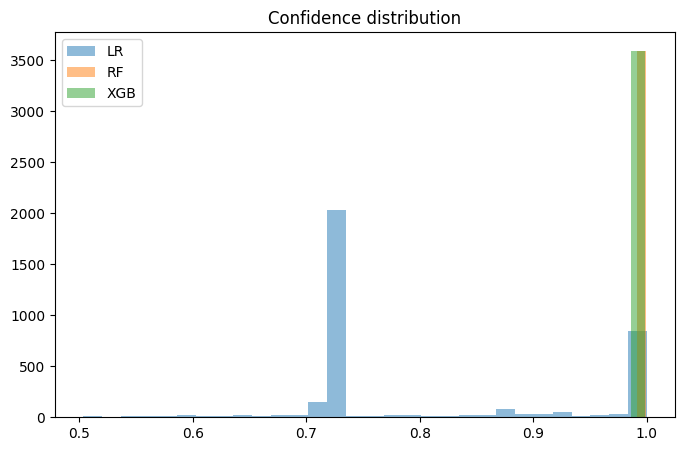

Saved confidence_hist.png


In [40]:
# Confidence histogram
def max_confidence(m, X):
    return m.predict_proba(X).max(axis=1)

conf_lr = max_confidence(lr_cal, X_val)
conf_rf = max_confidence(rf_cal, X_val)
conf_gb = max_confidence(gb_cal, X_val)

plt.figure(figsize=(8,5))
plt.hist(conf_lr, bins=30, alpha=0.5, label='LR')
plt.hist(conf_rf, bins=30, alpha=0.5, label='RF')
plt.hist(conf_gb, bins=30, alpha=0.5, label='XGB')
plt.legend()
plt.title('Confidence distribution')
plt.savefig('confidence_hist.png', bbox_inches='tight')
plt.show()
print('Saved confidence_hist.png')

In [41]:
# ---------- Refit on full cleaned data + export artifacts (replacement cell) ----------
import numpy as np, os, joblib, json, sklearn

# Ensure numeric_cols exists
if 'numeric_cols' not in globals():
    raise RuntimeError("numeric_cols not found. Run the feature selection cell first.")

# Reuse the cleaning function from earlier (or redefine if not in scope)
def clean_numeric_dataframe(df_in, numeric_cols, clip_quantiles=(0.01, 0.99), verbose=True):
    df_clean = df_in.copy()
    report = {'cols_with_inf': [], 'cols_winsorized': []}
    # Replace inf with NaN
    for c in numeric_cols:
        if c in df_clean.columns:
            col = df_clean[c]
            if np.isinf(col.values).any():
                df_clean[c].replace([np.inf, -np.inf], np.nan, inplace=True)
                report['cols_with_inf'].append(c)
    # Coerce to float64
    for c in numeric_cols:
        if c in df_clean.columns:
            df_clean[c] = pd.to_numeric(df_clean[c], errors='coerce').astype('float64')
    # Winsorize/clipping
    lower_q, upper_q = clip_quantiles
    if lower_q is not None and upper_q is not None:
        for c in numeric_cols:
            if c in df_clean.columns:
                s = df_clean[c].dropna()
                if s.empty:
                    continue
                qlow = s.quantile(lower_q)
                qhigh = s.quantile(upper_q)
                if qlow == qhigh:
                    continue
                if (s < qlow).any() or (s > qhigh).any():
                    df_clean[c] = df_clean[c].clip(lower=qlow, upper=qhigh)
                    report['cols_winsorized'].append(c)
    # Final checks
    any_inf = np.isinf(df_clean[numeric_cols].values).any()
    total_nans = int(df_clean[numeric_cols].isna().sum().sum())
    if verbose:
        print('Full-clean report — inf cols:', report['cols_with_inf'], 'winsorized:', report['cols_winsorized'])
        print('Post-clean — any_inf:', any_inf, 'total_nans_in_numeric:', total_nans)
    return df_clean, report

# 1) Clean the full X (this is the key step you missed)
print("Cleaning full X before refit...")
X_clean, rep_full = clean_numeric_dataframe(X, numeric_cols, clip_quantiles=(0.01,0.99), verbose=True)

# sanity check
if np.isinf(X_clean[numeric_cols].values).any():
    raise ValueError("Cleaning failed: inf still present in numeric columns of X_clean.")

# 2) Fit base pipelines on cleaned X (not the old X)
print("Fitting base pipelines on cleaned full X (this fits the preprocessor inside pipelines)...")
lr_base.fit(X_clean, y_enc)
rf_base.fit(X_clean, y_enc)
gb_base.fit(X_clean, y_enc)

# 3) Calibrate on full cleaned data
print("Calibrating on full data (this may take some minutes)...")
lr_cal_full = CalibratedClassifierCV(estimator=lr_base, cv=3, method='sigmoid'); lr_cal_full.fit(X_clean, y_enc)
rf_cal_full = CalibratedClassifierCV(estimator=rf_base, cv=3, method='sigmoid'); rf_cal_full.fit(X_clean, y_enc)
gb_cal_full = CalibratedClassifierCV(estimator=gb_base, cv=3, method='sigmoid'); gb_cal_full.fit(X_clean, y_enc)
print("Calibrated models on full data.")

# 4) Predict on the cleaned full X and save outputs
proba_lr_full = lr_cal_full.predict_proba(X_clean)
proba_rf_full = rf_cal_full.predict_proba(X_clean)
proba_gb_full = gb_cal_full.predict_proba(X_clean)

pred_lr_full_enc = lr_cal_full.predict(X_clean)
pred_rf_full_enc = rf_cal_full.predict(X_clean)
pred_gb_full_enc = gb_cal_full.predict(X_clean)

# 5) Save artifacts
os.makedirs('difficulty_model_artifacts', exist_ok=True)
fitted_preprocessor = lr_base.named_steps['preprocess']
joblib.dump(fitted_preprocessor, 'difficulty_model_artifacts/preprocessor.pkl')
joblib.dump(lr_cal_full, 'difficulty_model_artifacts/lr_model_calibrated.pkl')
joblib.dump(rf_cal_full, 'difficulty_model_artifacts/rf_model_calibrated.pkl')
joblib.dump(gb_cal_full, 'difficulty_model_artifacts/gb_model_calibrated.pkl')
joblib.dump(le, 'difficulty_model_artifacts/label_encoder.pkl')
# If tfidf exists in scope, save it as well
if 'tfidf' in globals():
    joblib.dump(tfidf, 'difficulty_model_artifacts/tfidf_vectorizer.pkl')

# Attach probabilities and preds to df_model (use original index order)
df_out = df_model.copy()
classes_enc = list(lr_cal_full.classes_)

for i, cls_enc in enumerate(classes_enc):
    cls_str = le.inverse_transform([cls_enc])[0]
    df_out[f'p_{cls_str}_lr_cal'] = proba_lr_full[:, i]
    df_out[f'p_{cls_str}_rf_cal'] = proba_rf_full[:, i]
    df_out[f'p_{cls_str}_gb_cal'] = proba_gb_full[:, i]

df_out['pred_label_lr'] = le.inverse_transform(pred_lr_full_enc)
df_out['pred_label_rf'] = le.inverse_transform(pred_rf_full_enc)
df_out['pred_label_gb'] = le.inverse_transform(pred_gb_full_enc)

OUTCSV = 'difficulty_v3_new.csv'
df_out.to_csv(OUTCSV, index=False)
print("Saved", OUTCSV)

# 6) metadata
meta = {
    'created_at': pd.Timestamp.now().isoformat(),
    'dataset_version': 'v3corrected',
    'n_rows': int(X_clean.shape[0]),
    'n_features': int(X_clean.shape[1]),
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'feature_list': [str(c) for c in (numeric_cols + categorical_cols)],
    'target_classes': list(le.classes_.tolist()),
    'class_order_enc': [int(x) for x in classes_enc],
    'sklearn_version': sklearn.__version__,
}
with open('difficulty_model_artifacts/metadata.json','w') as f:
    json.dump(meta, f, indent=2)

print('Saved artifacts and metadata to difficulty_model_artifacts/')
# -------------------------------------------------------------------------


Cleaning full X before refit...
Full-clean report — inf cols: ['avg_time_per_attempt'] winsorized: ['avg_attempt_count', 'avg_response_time', 'avg_time_per_attempt', 'num_attempts_total', 'num_students', 'text_length', 'word_count', 'ari', 'tfidf_l2_norm', 'readability_score']
Post-clean — any_inf: False total_nans_in_numeric: 198080
Fitting base pipelines on cleaned full X (this fits the preprocessor inside pipelines)...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Calibrating on full data (this may take some minutes)...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['cat_Entertainment: Books' 'cat_Entertainment: Film'
 'cat_Entertainment: Music' 'cat_Entertainment: Video Games'
 'cat_General Knowledge' 'cat_Geography' 'cat_History'
 'cat_Science & Nature' 'cat_Science: Computers' 'correct_binary'
 'word_count']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['category_clean']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  w

Calibrated models on full data.


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['cat_Entertainment: Books' 'cat_Entertainment: Film'
 'cat_Entertainment: Music' 'cat_Entertainment: Video Games'
 'cat_General Knowledge' 'cat_Geography' 'cat_History'
 'cat_Science & Nature' 'cat_Science: Computers' 'correct_binary'
 'word_count']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['category_clean']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['cat_Entertainment: Books' 'cat_Entertainment: Film'
 'cat_Entertainment: Music' 'cat_Entertainment: Video Games'
 'cat_General Knowledge' 'c

Saved difficulty_v3_new.csv
Saved artifacts and metadata to difficulty_model_artifacts/


## Inference helper — builds full input row with defaults and predicts using calibrated models

In [42]:
# Inference: load artifacts and define robust predictor that fills missing columns
import joblib, numpy as np, pandas as pd, os, json
ART_DIR = 'difficulty_model_artifacts'
preprocessor = joblib.load(os.path.join(ART_DIR, 'preprocessor.pkl'))
lr_model = joblib.load(os.path.join(ART_DIR, 'lr_model_calibrated.pkl'))
rf_model = joblib.load(os.path.join(ART_DIR, 'rf_model_calibrated.pkl'))
gb_model = joblib.load(os.path.join(ART_DIR, 'gb_model_calibrated.pkl'))
le = joblib.load(os.path.join(ART_DIR, 'label_encoder.pkl'))
tfidf = joblib.load(os.path.join(ART_DIR, 'tfidf_vectorizer.pkl'))
with open(os.path.join(ART_DIR,'metadata.json'),'r') as f:
    meta = json.load(f)
numeric_cols = meta['numeric_cols']
categorical_cols = meta['categorical_cols']
feature_list = meta['feature_list']
classes = le.classes_.tolist()
print('Loaded artifacts. Expecting numeric cols:', len(numeric_cols), 'and categorical cols:', len(categorical_cols))

Loaded artifacts. Expecting numeric cols: 44 and categorical cols: 2


In [43]:
# Build full input row function
def build_full_input_row_optionA(question, extras=None):
    '''
    extras: optional dict of values to override defaults for any raw column (e.g., category, avg_attempt_count)
    '''
    base = {}
    # text-derived features
    base['question_text'] = question
    base['ari'] = compute_ari(question)
    tf = tfidf.transform([question])
    base['tfidf_l2_norm'] = float(np.sqrt((tf.multiply(tf)).sum()).item())
    base['readability_score'] = avg_word_len(question)
    base.update(keyword_features(question))
    base.update(format_features(question))
    # extras override
    if extras:
        for k,v in extras.items():
            base[k] = v
    # Now ensure all numeric and categorical cols exist
    for c in numeric_cols + categorical_cols:
        if c not in base:
            # sensible defaults
            if c.startswith('is_') or c.startswith('has_'):
                base[c] = 0
            elif isinstance(df_model.get(c, None), (pd.Series,)) and pd.api.types.is_numeric_dtype(df_model[c]):
                base[c] = np.nan
            else:
                base[c] = np.nan
    # Create DataFrame and order columns as training
    row = pd.DataFrame([base])
    row = row[numeric_cols + categorical_cols]
    # coerce numeric
    for c in numeric_cols:
        row[c] = pd.to_numeric(row[c], errors='coerce')
    return row

# Robust predict using the calibrated pipeline models (they contain the preprocessor)
def predict_optionA(question, extras=None):
    row = build_full_input_row_optionA(question, extras=extras)
    # Pass DataFrame to models (they will internally transform)
    lr_enc = lr_model.predict(row)[0]
    rf_enc = rf_model.predict(row)[0]
    gb_enc = gb_model.predict(row)[0]
    lr_label = le.inverse_transform([lr_enc])[0]
    rf_label = le.inverse_transform([rf_enc])[0]
    gb_label = le.inverse_transform([gb_enc])[0]
    lr_proba = dict(zip(le.classes_.tolist(), lr_model.predict_proba(row)[0]))
    rf_proba = dict(zip(le.classes_.tolist(), rf_model.predict_proba(row)[0]))
    gb_proba = dict(zip(le.classes_.tolist(), gb_model.predict_proba(row)[0]))
    return {
        'input': question,
        'LogisticRegression': {'label': lr_label, 'proba': lr_proba},
        'RandomForest': {'label': rf_label, 'proba': rf_proba},
        'XGBoost': {'label': gb_label, 'proba': gb_proba},
        'final_recommendation': gb_label
    }

# Quick test example:
print(predict_optionA('What is AI?', extras={'category_clean':'General Knowledge'}))

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['cat_Entertainment: Books' 'cat_Entertainment: Film'
 'cat_Entertainment: Music' 'cat_Entertainment: Video Games'
 'cat_General Knowledge' 'cat_Geography' 'cat_History'
 'cat_Science & Nature' 'cat_Science: Computers' 'correct_binary'
 'word_count']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['category_clean']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['cat_Entertainment: Books' 'cat_Entertainment: Film'
 'cat_Entertainment: Music' 'cat_Entertainment: Video Games'
 'cat_General Knowledge' 'c

{'input': 'What is AI?', 'LogisticRegression': {'label': 'medium', 'proba': {'easy': np.float64(1.4045278913344953e-10), 'hard': np.float64(0.23647867959891722), 'medium': np.float64(0.76352132026063)}}, 'RandomForest': {'label': 'medium', 'proba': {'easy': np.float64(0.0002565058947164368), 'hard': np.float64(0.32453997270325735), 'medium': np.float64(0.6752035214020262)}}, 'XGBoost': {'label': 'medium', 'proba': {'easy': np.float64(0.00035218978588277784), 'hard': np.float64(0.021357087535754684), 'medium': np.float64(0.9782907226783625)}}, 'final_recommendation': 'medium'}


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['cat_Entertainment: Books' 'cat_Entertainment: Film'
 'cat_Entertainment: Music' 'cat_Entertainment: Video Games'
 'cat_General Knowledge' 'cat_Geography' 'cat_History'
 'cat_Science & Nature' 'cat_Science: Computers' 'correct_binary'
 'word_count']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['category_clean']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


In [ ]:
# ----------------------------
# 1) Robust cleaning + fitting + feature importance
# ----------------------------
import numpy as np, pandas as pd, os, matplotlib.pyplot as plt, joblib

OUT_DIR = "feature_importance_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# -- Diagnostics: report problem columns
def diag_X(X, numeric_cols, categorical_cols, large_threshold=1e100):
    print("X shape:", X.shape)
    stats = {}
    for c in numeric_cols:
        col = X[c] if c in X.columns else None
        if col is None:
            continue
        has_inf = np.isinf(col).any()
        n_nan = int(col.isna().sum())
        max_abs = float(np.nanmax(np.abs(col.astype(float))) if col.dropna().size>0 else 0.0)
        too_large = max_abs > large_threshold
        if has_inf or n_nan>0 or too_large:
            stats[c] = {"has_inf": bool(has_inf), "n_nan": n_nan, "max_abs": max_abs, "too_large": bool(too_large)}
    print("Problem numeric columns (inf/nan/too_large):", len(stats))
    if stats:
        for k,v in stats.items():
            print(k, v)
    # categorical checks
    cat_stats = {}
    for c in categorical_cols:
        if c not in X.columns: continue
        col = X[c]
        # check for inf in categorical (rare)
        has_inf = col.astype(str).str.contains("inf|-inf", na=False).any()
        n_nan = int(col.isna().sum())
        cat_stats[c] = {"has_inf_like": bool(has_inf), "n_nan": n_nan}
    print("Categorical columns issues:", {k:v for k,v in cat_stats.items() if v['has_inf_like'] or v['n_nan']>0})
    return stats, cat_stats

print("Before cleaning diagnostic:")
diag_X(X, numeric_cols, categorical_cols)

# -- Cleaning function
def robust_clean_X(X_in, numeric_cols, categorical_cols, clip_q=(0.01, 0.99), fill_strategy="median", large_value_cap=1e18):
    Xc = X_in.copy()
    # numeric: replace inf, cast, clip by quantiles, cap extreme absolute values, impute
    for c in numeric_cols:
        if c not in Xc.columns:
            continue
        # replace inf with NaN
        Xc[c].replace([np.inf, -np.inf], np.nan, inplace=True)
        # coerce to numeric
        Xc[c] = pd.to_numeric(Xc[c], errors="coerce").astype("float64")
        s = Xc[c].dropna()
        if s.empty:
            # nothing to do
            continue
        low = s.quantile(clip_q[0])
        high = s.quantile(clip_q[1])
        if pd.notna(low) and pd.notna(high) and low < high:
            Xc[c] = Xc[c].clip(lower=low, upper=high)
        # now cap any absolute extreme values (safety)
        Xc[c] = Xc[c].where(Xc[c].abs() <= large_value_cap, np.sign(Xc[c]) * large_value_cap)
        # impute
        if fill_strategy == "median":
            fill_val = s.median()
        elif fill_strategy == "mean":
            fill_val = s.mean()
        else:
            fill_val = 0.0
        Xc[c] = Xc[c].fillna(fill_val)
    # categorical: fill na with 'missing' and ensure strings
    for c in categorical_cols:
        if c not in Xc.columns:
            continue
        Xc[c] = Xc[c].fillna("missing").astype(str)
    return Xc

# Clean X and re-diagnose
X_clean = robust_clean_X(X, numeric_cols, categorical_cols, clip_q=(0.01,0.99), fill_strategy="median", large_value_cap=1e18)
print("\nAfter cleaning diagnostic:")
diag_X(X_clean, numeric_cols, categorical_cols)

# Replace X with X_clean for downstream operations
X = X_clean

# -- Fit base pipelines on cleaned X (use y_enc)
print("\nFitting base pipelines on full X (this will re-fit the models on full data):")
try:
    lr_base.fit(X, y_enc)
    rf_base.fit(X, y_enc)
    gb_base.fit(X, y_enc)
except Exception as e:
    print("Error during fit:", e)
    raise
print("Fitting complete. Proceeding to compute feature importances...")

# ----------------------------------------------------------------
# Feature importance code (same logic as earlier)
# ----------------------------------------------------------------
def get_feature_names_safe(preprocessor, numeric_cols, categorical_cols):
    try:
        names = preprocessor.get_feature_names_out()
        return [str(n) for n in names]
    except Exception:
        names = list(numeric_cols)
        try:
            cat_transformer = preprocessor.named_transformers_['cat']
            ohe = cat_transformer.named_steps.get('onehot', None)
            if ohe is not None:
                try:
                    ohe_names = list(ohe.get_feature_names_out(categorical_cols))
                except Exception:
                    ohe_names = list(ohe.get_feature_names(categorical_cols))
                names += [str(n) for n in ohe_names]
        except Exception:
            pass
        return names

feat_names = get_feature_names_safe(preprocessor, numeric_cols, categorical_cols)
print("Number of post-preprocessing features found:", len(feat_names))

# extract importances
rf_model = rf_base.named_steps['model']
rf_imp = rf_model.feature_importances_ if hasattr(rf_model, 'feature_importances_') else np.zeros(len(feat_names))

try:
    gb_model = gb_base.named_steps['model']
    xgb_imp = gb_model.feature_importances_ if hasattr(gb_model, 'feature_importances_') else None
except Exception:
    xgb_imp = None

lr_model = lr_base.named_steps['model']
lr_coef_abs = np.mean(np.abs(lr_model.coef_), axis=0) if hasattr(lr_model, 'coef_') else np.zeros(len(feat_names))

# align lengths
n = len(feat_names)
def pad_or_trim(arr):
    arr = np.asarray(arr)
    if arr.size < n:
        return np.concatenate([arr, np.zeros(n - arr.size)])
    else:
        return arr[:n]

rf_imp = pad_or_trim(rf_imp)
lr_coef_abs = pad_or_trim(lr_coef_abs)
xgb_imp = pad_or_trim(xgb_imp) if xgb_imp is not None else np.zeros(n)

imp_df = pd.DataFrame({
    "feature": feat_names,
    "rf_imp": rf_imp,
    "xgb_imp": xgb_imp,
    "lr_coef_abs": lr_coef_abs
})
imp_df = imp_df.fillna(0.0)
imp_df_sorted = imp_df.sort_values(by=["rf_imp", "xgb_imp", "lr_coef_abs"], ascending=False).reset_index(drop=True)
csv_path = os.path.join(OUT_DIR, "feature_importances_full.csv")
imp_df_sorted.to_csv(csv_path, index=False)
print("Saved feature_importances_full.csv ->", csv_path)

# Plot top features
TOP_N = 30
def plot_top(colname, title, outname, topn=TOP_N):
    if imp_df_sorted[colname].sum() <= 0:
        print(f"Skipping {colname} plot (no signal).")
        return
    top = imp_df_sorted.head(topn)
    plt.figure(figsize=(8, min(0.25*topn + 1, 12)))
    plt.barh(top['feature'][::-1], top[colname][::-1])
    plt.title(title)
    plt.xlabel(colname)
    plt.tight_layout()
    path = os.path.join(OUT_DIR, outname)
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    print("Saved", path)

plot_top("rf_imp", "Top features by Random Forest importance", "feature_importance_rf.png")
if imp_df_sorted['xgb_imp'].sum() > 0:
    plot_top("xgb_imp", "Top features by XGBoost importance", "feature_importance_xgb.png")
plot_top("lr_coef_abs", "Top features by |LR coefficient| (avg across classes)", "feature_coefficients_lr.png")

print("All done. Check directory:", OUT_DIR)
